In [1]:
import numpy as np
import pylab as pl
from scipy import spatial

In [2]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

## 空间算法库-spatial

### 计算最近旁点

In [3]:
x = np.sort(np.random.rand(100))
idx = np.searchsorted(x, 0.5)
print (x[idx], x[idx - 1]) #距离0.5最近的数是这两个数中的一个

0.5010357336095952 0.49647140351928987


In [4]:
from scipy import spatial
np.random.seed(42)
N = 100
points = np.random.uniform(-1, 1, (N, 2))
kd = spatial.cKDTree(points)

targets = np.array([(0, 0), (0.5, 0.5), (-0.5, 0.5), (0.5, -0.5), (-0.5, -0.5)])
dist, idx = kd.query(targets, 3)


In [5]:
r = 0.2
idx2 = kd.query_ball_point(targets, r)
idx2

array([list([48]), list([37, 78]), list([22, 79, 92]), list([6, 35, 58]),
       list([7, 42, 55, 83])], dtype=object)

In [6]:
idx3 = kd.query_pairs(0.1) - kd.query_pairs(0.08)
idx3

{(1, 46),
 (3, 21),
 (3, 82),
 (3, 95),
 (5, 16),
 (9, 30),
 (10, 87),
 (11, 42),
 (11, 97),
 (18, 41),
 (29, 74),
 (32, 51),
 (37, 78),
 (39, 61),
 (41, 61),
 (50, 84),
 (55, 83),
 (73, 81)}

D:\Apps\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
D:\Apps\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


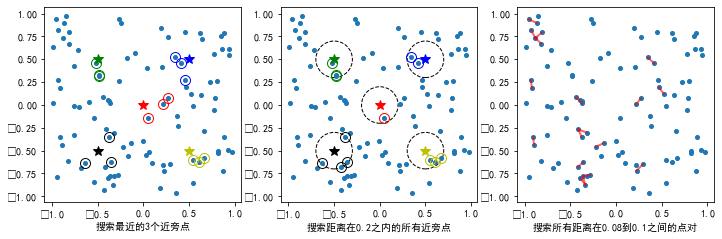

In [7]:
#%figonly=用cKDTree寻找近旁点
x, y = points.T
colors = "r", "b", "g", "y", "k"

fig, (ax1, ax2, ax3) = pl.subplots(1, 3, figsize=(12, 4))

for ax in ax1, ax2, ax3:
    ax.set_aspect("equal")
    ax.plot(x, y, "o", markersize=4)
    
for ax in ax1, ax2:
    for i in range(len(targets)):
        c = colors[i]
        tx, ty = targets[i]
        ax.plot([tx], [ty], "*", markersize=10, color=c)

for i in range(len(targets)):
    nx, ny = points[idx[i]].T
    ax1.plot(nx, ny, "o", markersize=10, markerfacecolor="None", 
             markeredgecolor=colors[i], markeredgewidth=1)
    
    nx, ny = points[idx2[i]].T
    ax2.plot(nx, ny, "o", markersize=10, markerfacecolor="None", 
             markeredgecolor=colors[i], markeredgewidth=1)
    
    ax2.add_artist(pl.Circle(targets[i], r, fill=None, linestyle="dashed"))
    
for pidx1, pidx2 in idx3:
    sx, sy = points[pidx1]
    ex, ey = points[pidx2]
    ax3.plot([sx, ex], [sy, ey], "r", linewidth=2, alpha=0.6)
    
ax1.set_xlabel(u"搜索最近的3个近旁点")
ax2.set_xlabel(u"搜索距离在0.2之内的所有近旁点")
ax3.set_xlabel(u"搜索所有距离在0.08到0.1之间的点对");

In [8]:
from scipy.spatial import distance
dist1 = distance.squareform(distance.pdist(points))
dist2 = distance.cdist(points, targets)
print(dist1.shape)
print(dist2.shape)

(100, 100)
(100, 5)


In [9]:
print (dist[:, 0]) # cKDTree.query()返回的与targets最近的距离
print (np.min(dist2, axis=0))

[0.15188266 0.09595807 0.05009422 0.11180181 0.19015485]
[0.15188266 0.09595807 0.05009422 0.11180181 0.19015485]


In [10]:
dist1[np.diag_indices(len(points))] = np.inf
nearest_pair = np.unravel_index(np.argmin(dist1), dist1.shape)
print (nearest_pair, dist1[nearest_pair])

(22, 92) 0.005346210248158245


In [11]:
dist, idx = kd.query(points, 2)
print (idx[np.argmin(dist[:, 1])], np.min(dist[:, 1]))

[22 92] 0.005346210248158245


In [12]:
N = 1000000
start = np.random.uniform(0, 100, N)
span = np.random.uniform(0.01, 1, N)
span = np.clip(span, 2, 100)
end = start + span

In [13]:
def naive_count_at(start, end, time):
    mask = (start < time) & (end > time)
    return np.sum(mask)

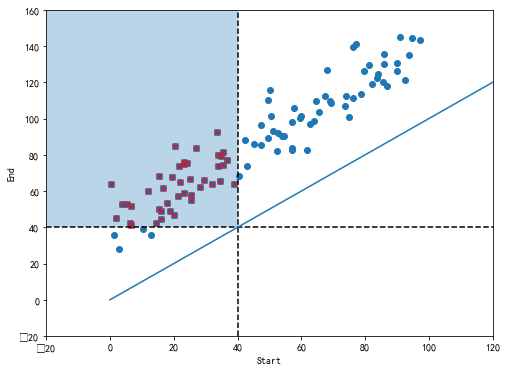

In [14]:
#%figonly=使用二维K-d树搜索指定区间的在线用户
def _():
    N = 100
    start = np.random.uniform(0, 100, N)
    span = np.random.normal(40, 10, N)
    span = np.clip(span, 2, 100)
    end = start + span

    time = 40
    
    fig, ax = pl.subplots(figsize=(8, 6))
    ax.scatter(start, end)
    mask = (start < time) & (end > time)
    start2, end2 = start[mask], end[mask]
    ax.scatter(start2, end2, marker="x", color="red")
    rect = pl.Rectangle((-20, 40), 60, 120, alpha=0.3)
    ax.add_patch(rect)
    ax.axhline(time, color="k", ls="--")
    ax.axvline(time, color="k", ls="--")
    ax.set_xlabel("Start")
    ax.set_ylabel("End")
    ax.set_xlim(-20, 120)
    ax.set_ylim(-20, 160)
    ax.plot([0, 120], [0, 120])

_()

In [15]:
class KdSearch(object):
    def __init__(self, start, end, leafsize=10):
        self.tree = spatial.cKDTree(np.c_[start, end], leafsize=leafsize)
        self.max_time = np.max(end)
      
    def count_at(self, time):
        max_time = self.max_time
        to_search = spatial.cKDTree([[time - max_time, time + max_time]])
        return self.tree.count_neighbors(to_search, max_time, p=np.inf)
    
naive_count_at(start, end, 40) == KdSearch(start, end).count_at(40)

True

> **QUESTION**

> 请读者研究点数`N`和`leafsize`参数与创建K-d树和搜索时间之间的关系。

### 凸包

In [16]:
np.random.seed(42)
points2d = np.random.rand(10, 2)
ch2d = spatial.ConvexHull(points2d)
print(ch2d.simplices)
print(ch2d.vertices)

[[2 5]
 [2 6]
 [0 5]
 [1 6]
 [1 0]]
[5 2 6 1 0]


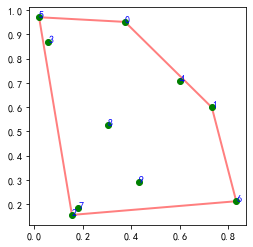

In [17]:
#%fig=二维平面上的凸包
poly = pl.Polygon(points2d[ch2d.vertices], fill=None, lw=2, color="r", alpha=0.5)
ax = pl.subplot(aspect="equal")
pl.plot(points2d[:, 0], points2d[:, 1], "go")
for i, pos in enumerate(points2d):
    pl.text(pos[0], pos[1], str(i), color="blue")
ax.add_artist(poly);

In [18]:
np.random.seed(42)
points3d = np.random.rand(40, 3)
ch3d = spatial.ConvexHull(points3d)
ch3d.simplices.shape

(38, 3)

### 沃罗诺伊图

In [19]:
points2d = np.array([[0.2, 0.1], [0.5, 0.5], [0.8, 0.1],
                     [0.5, 0.8], [0.3, 0.6], [0.7, 0.6], [0.5, 0.35]])
vo = spatial.Voronoi(points2d)

In [20]:
print(vo.vertices); print(vo.regions); print(vo.ridge_vertices)

[[0.5    0.045 ]
 [0.245  0.351 ]
 [0.755  0.351 ]
 [0.3375 0.425 ]
 [0.6625 0.425 ]
 [0.45   0.65  ]
 [0.55   0.65  ]]
[[-1, 0, 1], [-1, 0, 2], [], [6, 4, 3, 5], [5, -1, 1, 3], [4, 2, 0, 1, 3], [6, -1, 2, 4], [6, -1, 5]]
[[-1, 0], [0, 1], [-1, 1], [0, 2], [-1, 2], [3, 5], [3, 4], [4, 6], [5, 6], [1, 3], [-1, 5], [2, 4], [-1, 6]]


In [21]:
bound = np.array([[-100, -100], [-100,  100], 
                  [ 100,  100], [ 100, -100]])
vo2 = spatial.Voronoi(np.vstack((points2d, bound)))

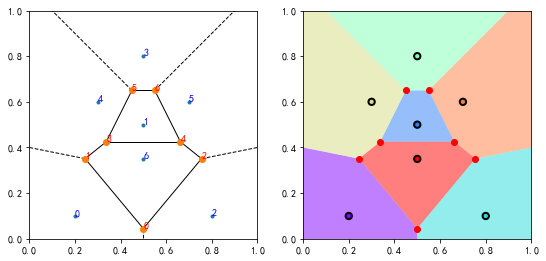

In [22]:
#%figonly=沃罗诺伊图将空间分割为多个区域
fig, (ax1, ax2) = pl.subplots(1, 2, figsize=(9, 4.5))
ax1.set_aspect("equal")
ax2.set_aspect("equal")
spatial.voronoi_plot_2d(vo, ax=ax1)
for i, v in enumerate(vo.vertices):
    ax1.text(v[0], v[1], str(i), color="red")
    
for i, p in enumerate(points2d):
    ax1.text(p[0], p[1], str(i), color="blue")

n = len(points2d)
color = pl.cm.rainbow(np.linspace(0, 1, n))
for i in range(n):
    idx = vo2.point_region[i]
    region = vo2.regions[idx]
    poly = pl.Polygon(vo2.vertices[region], facecolor=color[i], alpha=0.5, zorder=0)
    ax2.add_artist(poly)
ax2.scatter(points2d[:, 0], points2d[:, 1], s=40, c=color, linewidths=2, edgecolors="k")
ax2.plot(vo2.vertices[:, 0], vo2.vertices[:, 1], "ro", ms=6)

for ax in ax1, ax2:
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)

In [23]:
print (vo.point_region)
print (vo.regions[6])

[0 3 1 7 4 6 5]
[6, -1, 2, 4]


### 德劳内三角化

In [24]:
x = np.array([46.445, 263.251, 174.176, 280.899, 280.899, 
              189.358, 135.521, 29.638, 101.907, 226.665])
y = np.array([287.865, 250.891, 287.865, 160.975, 54.252,
              160.975, 232.404, 179.187, 35.765, 71.361])
points2d = np.c_[x, y]
dy = spatial.Delaunay(points2d)
vo = spatial.Voronoi(points2d) 
print(dy.simplices)
print(vo.vertices)

[[8 5 7]
 [1 5 3]
 [5 6 7]
 [6 0 7]
 [0 6 2]
 [6 1 2]
 [1 6 5]
 [9 5 8]
 [4 9 8]
 [5 9 3]
 [9 4 3]]
[[104.58977484 127.03566055]
 [235.1285     198.68143374]
 [107.83960707 155.53682482]
 [ 71.22104881 228.39479887]
 [110.3105     291.17642838]
 [201.40695449 227.68436282]
 [201.61895891 226.21958623]
 [152.96231864  93.25060083]
 [205.40381294 -90.5480267 ]
 [235.1285     127.45701644]
 [267.91709907 107.6135    ]]


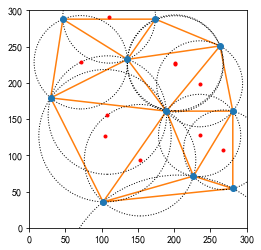

In [25]:
#%fig=德劳内三角形的外接圆与圆心
cx, cy = vo.vertices.T

ax = pl.subplot(aspect="equal")
spatial.delaunay_plot_2d(dy, ax=ax)
ax.plot(cx, cy, "r.")
for i, (cx, cy) in enumerate(vo.vertices):
    px, py = points2d[dy.simplices[i, 0]]
    radius = np.hypot(cx - px, cy - py)
    circle = pl.Circle((cx, cy), radius, fill=False, ls="dotted")
    ax.add_artist(circle)
ax.set_xlim(0, 300)
ax.set_ylim(0, 300);